In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from skimage.metrics import structural_similarity as ssim
from featureExtraction import featureExtraction
from bundleAdjustment import bundleAdjustment
from gainCompensation import gainCompensation
from stitcher import Stitcher

## UDIS-D comparison

In [2]:
def image_loader():
    input1 = "./data/UDIS-D/input1/"
    input2 = "./data/UDIS-D/input2/"
    output = "./data/UDIS-D/Ours/"
    image_list = []
    gt_list = []
    i = 1
    for filename in os.listdir(input1):
        img1 = cv.imread(os.path.join(input1,filename))
        img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
        img2 = cv.imread(os.path.join(input2,filename))
        img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
        img3 = cv.imread(os.path.join(output,filename))
        img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
        image_list.append([img1,img2])
        gt_list.append(img3)
        if i == 5:
            break
        i += 1

    return image_list, gt_list

In [3]:
def apply_filter(filter,image):
    # filter is a 1x3 array
    # image is a 2D array with 3 channels
    # returns a 2D array with 3 channels

    # convert image to float
    image = image.astype(np.float32)
    # apply filter
    image[:,:,0] = image[:,:,0]*filter[0]
    image[:,:,1] = image[:,:,1]*filter[1]
    image[:,:,2] = image[:,:,2]*filter[2]
    # convert back to uint8
    image = image.astype(np.uint8)
    return image

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

def trim2(img):
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  _,thresh = cv.threshold(gray,1,255,cv.THRESH_BINARY)
  contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  x,y,w,h = cv.boundingRect(cnt)
  crop = img[y:y+h,x:x+w]
  return crop


def stitch_images(image1,image2,H,gain1,gain2):
    image1 = apply_filter(gain1,image1)
    image2 = apply_filter(gain2,image2)


    width = 2*image1.shape[1] + image2.shape[1]
    height = 2*image1.shape[0] + image2.shape[0]

    # offset Homography by width and height of first image
    offset_matrix = np.eye(3)
    offset_matrix[0][2] = image1.shape[1]
    offset_matrix[1][2] = image1.shape[0]
    H_new = offset_matrix @ H
    result = cv.warpPerspective(image1, H_new, (width, height))
    result[image1.shape[0]:image2.shape[0]+image1.shape[0], image1.shape[1]:image2.shape[1]+image1.shape[1]] = image2
    return trim2(result)

In [4]:
def generatePanaroma(img_list):
    fe = featureExtraction(img_list.copy(),method="FLANN")
    fe.run()
    numMatches=np.zeros((len(img_list),len(img_list)))
    for i in range(len(img_list)):
        for j in range(len(img_list)):
            if fe.matches[i][j]==None:
                numMatches[i,j]=0
                continue
            numMatches[i,j]=-len(fe.matches[i][j]) # we take -ve wts as we want to retain the edges with more matches while applying MST
    BA=bundleAdjustment(fe.matches.copy(),numMatches,fe.homographies.copy(),img_list.copy(),fe.keypoints)
    BA.run()
    gain_list = []
    gainCompensation(img_list.copy(),fe.matches.copy(),fe.homographies.copy(),gainList=gain_list)
    
    for i in range(len(BA.paths)):
        path = BA.paths[i]
        img_list = []
        H_list = [np.eye(3)]
        for j in path:
            img_list.append(BA.imgList[j])
        for H in BA.bundleHomo[i]:
            H_list.append(H)
        
        st = Stitcher(img_list,H_list)
        st.stitch()
        pano = st.panaroma
        plt.imshow(pano)
        plt.show()




In [5]:
def evaluate_img(img1,img2):
    # evaluate the quality of the stitched image
    # we caluclate mse between the two images
    # we also calculate the ssim between the two images

    # convert to grayscale
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    # resize the images to same size
    img2 = cv.resize(img2,(img1.shape[1],img1.shape[0]))

    h,w = img1.shape
    diff = cv.subtract(img1,img2)
    err = np.sum(diff**2)
    mse = err/float(h*w)
    ssim_score = ssim(img1,img2)

    return mse,ssim_score

Extracting SIFT features...
Generating matches...
Processing matches...
Computing homographies...
Computing adjacency matrix...
Building network and ordering...
Number of panoramas detected:  1
Performing bundle adjustment for each panorama...
Panorama  1
Completed bundle adjustment for all panoramas


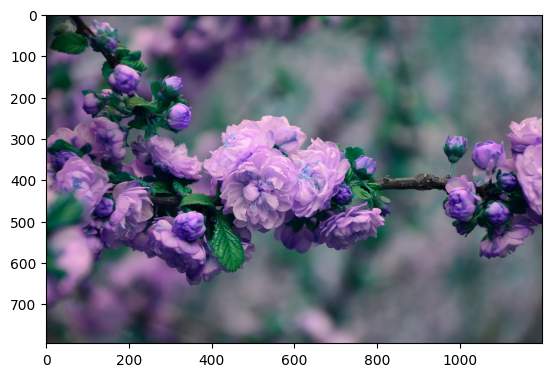

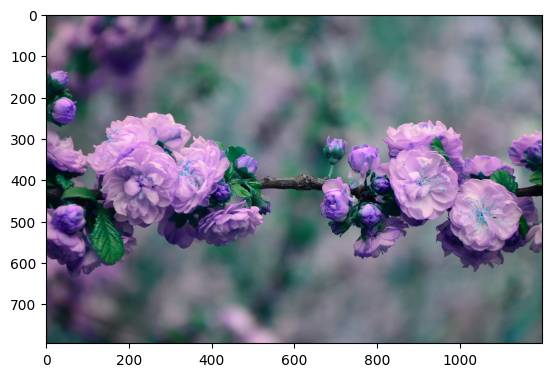

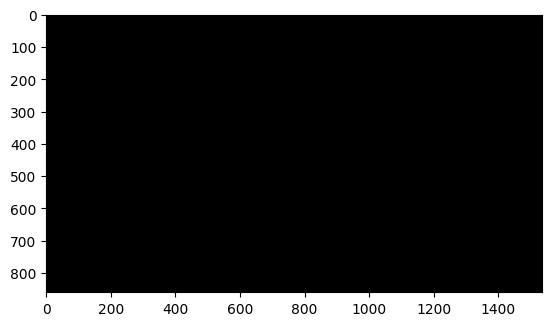

In [6]:
flower_path = "./data/flower/"
flower_list = []
i = 1
for filename in os.listdir(flower_path):
    img = cv.imread(os.path.join(flower_path,filename))
    flower_list.append(img)
    if i == 2:
        break
    i += 1

# stitch the flower images
generatePanaroma(flower_list)
# flower_stitched = cv.cvtColor(flower_stitched, cv.COLOR_BGR2RGB)
# plt.imshow(flower_stitched)


In [7]:
# all_images, gt_images = image_loader()
# for i in range(len(all_images)):
#     img_list = all_images[i]
#     stitched = generatePanaroma(img_list)
#     # stitched = cv.resize(stitched,(gt_images[i].shape[1],gt_images[i].shape[0]))
#     # mse,ssim_score = evaluate_img(stitched,gt_images[i])
#     ax, fig = plt.subplots(1,2)
#     fig[0].imshow(gt_images[i])
#     fig[1].imshow(stitched)
#     plt.show()
#     # print("MSE: ",mse)
#     # print("SSIM: ",ssim_score)
